# English - Alice in wonderland

## Data preparation

In [1]:
from importlib import reload

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pavlem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
import preprocessor
preprocessor = reload(preprocessor)


pp = preprocessor.Preprocessor("data/original/alice_in_wonderland.txt", "eng", False)
cleaned_corpus = pp.process()
pp.split(cleaned_corpus)

[later editions continued as follows When the sands are all dry, he is gay as a lark, And will talk in contemptuous tones of the Shark, But, when the tide rises and sharks are around, His voice has a timid and tremulous sound.].
[later editions continued as follows The Panther took pie-crust, and gravy, and meat, While the Owl had the dish as its share of the treat.
Number of unique characters: 35
Number of characters: 367
dict_keys(['[', 'l', 'a', 't', 'e', 'r', ' ', 'd', 'i', 'o', 'n', 's', 'c', 'u', 'f', 'w', 'W', 'h', 'y', ',', 'g', 'k', 'A', 'm', 'p', 'S', 'B', 'H', 'v', '.', ']', 'T', 'P', '-', 'O'])


## Subword segmentation

In [2]:
import sentpiece
sentpiece = reload(sentpiece)

# Character level train vocabular size = 68
# Character level test vocabular size = 68


NUM_CHARS = 2500
TRAIN_DATA_PATH = "data/processed/eng_test.txt"
MODEL_NAME = "eng_model_lrg_base"
TYPE = "_train"

In [41]:
sentpiece.train_model(TRAIN_DATA_PATH, MODEL_NAME + TYPE, NUM_CHARS)

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/processed/eng_test.txt
  input_format: 
  model_prefix: eng_model_lrg_base_test
  model_type: BPE
  vocab_size: 2500
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whit

In [42]:
!mv $MODEL_NAME* spm_models/

In [43]:
SEG_DATA_FILE = "eng_lrg_base_test.txt"


sentpiece.segmentation(TRAIN_DATA_PATH, MODEL_NAME + TYPE, SEG_DATA_FILE)

## Train LM

In [47]:
TRAIN_SEG_DATA_PATH = "data/segmented/eng_lrg_base_train.txt"
TEST_SEG_DATA_PATH = "data/segmented/eng_lrg_base_test.txt"
NUM_LAYERS = 60
CLASS = 2400
BPTT = 3


!bash train_script.sh $TRAIN_SEG_DATA_PATH $TEST_SEG_DATA_PATH $NUM_LAYERS $CLASS $BPTT

rm: cannot remove 'rnnlm/models/model': No such file or directory
rm: cannot remove 'rnnlm/models/model.output.txt': No such file or directory
debug mode: 2
train file: data/segmented/eng_lrg_base_train.txt
valid file: data/segmented/eng_lrg_base_test.txt
class size: 2400
Hidden layer size: 60
BPTT: 3
Rand seed: 1
rnnlm file: model
Starting training using file data/segmented/eng_lrg_base_train.txt
Vocab size: 2224
Words in train file: 29551
Iter:   0	Alpha: 0.100000	   TRAIN entropy: 8.6827    Words/sec: 2747.9   VALID entropy: 7.8984
Iter:   1	Alpha: 0.100000	   TRAIN entropy: 7.9714    Words/sec: 2827.0   VALID entropy: 7.4885
Iter:   2	Alpha: 0.100000	   TRAIN entropy: 7.5295    Words/sec: 2906.3   VALID entropy: 7.3258
Iter:   3	Alpha: 0.100000	   TRAIN entropy: 7.2084    Words/sec: 2841.0   VALID entropy: 7.2263
Iter:   4	Alpha: 0.100000	   TRAIN entropy: 6.9551    Words/sec: 3138.2   VALID entropy: 7.1319
Iter:   5	Alpha: 0.100000	   TRAIN entropy: 6.7439    Words/sec: 3090.6   V

In [45]:
MODEL_OUTPUT = MODEL_NAME + ".output.txt"

!mv model $MODEL_NAME
!mv model.output.txt $MODEL_OUTPUT

!mv $MODEL_NAME $MODEL_OUTPUT rnnlm_models/

## Data generation

In [3]:
GEN_DATA_PATH = f"data/generated/{MODEL_NAME}/"
MODEL_PATH = f"./rnnlm_models/{MODEL_NAME}"

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [26]:
# Decoding generated texts

for i in range(1, 8):
    size = 10**i
    sentpiece.desegmentation(f"data/generated/eng_model_lrg_ft/{size}.txt", MODEL_NAME + TYPE)

## Out-of-vocabulary results

In [2]:
import oov_eng
oov_module = reload(oov_eng)

In [3]:
# Initiate OOV object

comparer = oov_module.OOV()

Baseline OOV rate
Number of unseen words: 379.0
Total number of test words: 5415.0
OOV rate: 7.0%


In [4]:
oov_rates = comparer.check_oov()

for key, values in sorted(oov_rates.items()):
    print(f"{key}: {round(values[-1][1] * 100, 2)}%")

eng_model_chr_base: 4.95%
eng_model_chr_ft: 4.71%
eng_model_lrg_base: 5.3%
eng_model_lrg_ft: 5.13%
eng_model_sml_base: 4.73%
eng_model_sml_ft: 4.71%


No handles with labels found to put in legend.


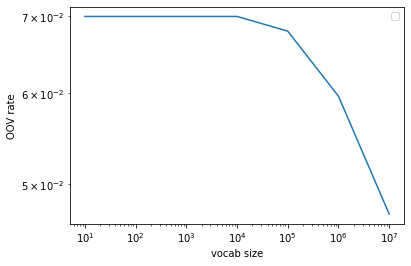

In [5]:
# comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_chr_ft"]})
comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_chr_ft"]})

No handles with labels found to put in legend.


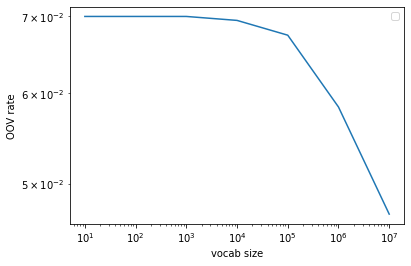

In [6]:
# comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_sml_base"]})
comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_sml_ft"]})

No handles with labels found to put in legend.


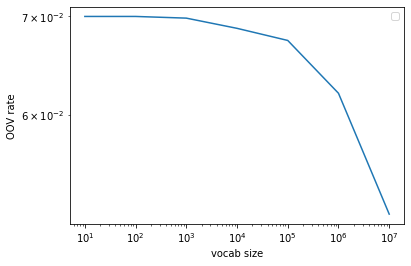

In [7]:
# comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_lrg_base"]})
comparer.plot_oov_rates({value[0]: value[1] for value in oov_rates["eng_model_lrg_ft"]})

## Observations

### baselines
| Language |   Level   | Voc. size | Hyperparams | Perplexity | OOV rate BS: 7.00% |
|:--------:|:---------:|:---------:|:-----------:|:----------:|:------------------:|
|  English | Character |     68    |  40-9999-3  |  5.495792  |        4.95%       |
|  English |   Small   |    100    |  40-9999-3  |  14.253632 |        4.73%       |
|  English |   Large   |    2500   |  40-9999-3  |  63.051203 |        5.30%       |

### tuned models 
| Language |   Level   | Voc. size | Hyperparams | Perplexity | OOV rate BS: 7.00% |
|:--------:|:---------:|:---------:|:-----------:|:----------:|:------------------:|
|  English | Character |     68    |   100-65-3  |  4.616152  |        4.71%       |
|  English |   Small   |    100    |   80-90-5   |  13.368461 |        4.71%       |
|  English |   Large   |    2500   |  60-2400-3  |  59.681927 |        5.13%       |

It can be seen similar trends for each level. With closer look, for smaller granularities (character and small level), visible decreases start after 10^4 text length, while in case of large level a noticeable decrease can be seen after 10^3 text length. In a production, we would use small level model, since oov-rates between it and character level models are similar, but hidden size is higher with character level, thus, we might have overfitting to some degree. Also, with higher granularity words correctness and coherence of the text increase.



## Inspection of 100.txts
For fine-tuned character level: <br>
`I Hatce'd SOMEy-can just bent-or,' wenter.'. Phear diender under.. `We cake something you was!. Th <br>

For fine-tuned small level: <br>
as larke quabling to said then treasnyed,' it half said to the door outcen, from once or taiced it. As quite scearst?' neal withow and at she stoo<br>

"For fine-tuned large level: <br>
voice, before she hadme trouble puppyven its head. Alice waited in a great grunted fire on the firstched getting usu and howling high.. `They did you know up to this day,' with the March Turtle: she had al chill, with one of paw of the youth, which got the back of the distance, and said, `Speak be invit something will you, will you\" have at the right? grow gave, could,' said Alice: `aslled! shallen him

## Analysis
Character-level model is not able to generate grammatically correct words. On the other hand, with increased vocabulary size, like for small level the model starts to generate some words correctly, while for the large level model we can observe even some coherence in the text.

# Bengali

In [3]:
from importlib import reload
import os

In [2]:
import preprocessor
preprocessor = reload(preprocessor)


pp = preprocessor.Preprocessor("data/original/bengali_corpus.txt", "bng")
cleaned_corpus = pp.process()
pp.split(cleaned_corpus)

10861 2716


## Subword segmentation

In [4]:
import sentpiece
sentpiece = reload(sentpiece)

In [4]:
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
TEST_DATA_PATH = "data/processed/bng_test.txt"
models, test_models = [], []
seg_train_path, seg_test_path = [], []
start=200
stop=250
step=50

for vocab_size in range(start, stop, step):
    train_model_name = "bng_train_"+str(vocab_size)
    test_model_name = "bng_test_"+str(vocab_size)
    tr_seg_data_path = f"bng_tr_chr_{str(vocab_size)}.txt"
    te_seg_data_path = f"bng_te_chr_{str(vocab_size)}.txt"
    
    sentpiece.train_model(TRAIN_DATA_PATH, train_model_name, vocab_size, lang="bng")
    models.append(train_model_name)
    seg_train_path.append(tr_seg_data_path)
    
    sentpiece.train_model(TEST_DATA_PATH, test_model_name, vocab_size, lang="bng")
    test_models.append(test_model_name)
    seg_test_path.append(te_seg_data_path)
    

In [5]:
import shutil, glob, os

for model in models+test_models:
    for file in glob.glob(f'{model}*'):
        cwd = os.getcwd() 
        src = cwd
        dst = cwd + "/spm_models/"
        shutil.move(os.path.join(src, file), os.path.join(dst, file))

In [6]:
for model, seg_path in zip(models,seg_train_path):
    sentpiece.segmentation(TRAIN_DATA_PATH, model, seg_path)

for model, seg_path in zip(test_models,seg_test_path):
    sentpiece.segmentation(TEST_DATA_PATH, model, seg_path)

In [11]:
## a snippet of generated files
selected_files = ["data/segmented/bng_tr_chr_50.txt", "data/segmented/bng_tr_chr_200.txt", "data/segmented/bng_tr_wd_1500.txt"]
for path in selected_files:
    with open(path) as f:
        data = f.read()[:400]
        print(f"{path[path.rfind('_')+1:]} : {data}")
        print("\n")

50.txt : ▁ য ত ্ ত স ব ▁ প া প ন ▁ শ া ল া র ▁ ফ া জ ল া ম ী ▁ প া প ন ▁ শ া ল া ▁ র ে ▁ র ি ম া ন ্ ড ে ▁ ন ে ও য ় া ▁ দ র ক া র জ ি ল ্ ল ু র ▁ র হ ম া ন ▁ স ্ য া র ে র ▁ ছ ে ল ে ▁ এ ত ো ▁ ব ড ় ▁ জ া র জ ▁ হ ব ে ▁ এ ট া ▁ এ ক ট া ▁ দ ে শ ে র ▁ ম া ন ু ষ ▁ ক ো ন ো ▁ দ ি ন ▁ ও ▁ ভ া ব ত ে ▁ প া র ে ন ি ▁ ধ ন ্ য ব া দ ▁ ত া হ স ি ন ▁ ভ া ই ▁ শ া ল া ▁ ল ু চ ্ চ া ▁ দ ে খ ত ে ▁ প া ঠ া র ▁ ম ত ▁ দ ে খ া 


200.txt : ▁য ত ্ত স ব ▁পা পন ▁শ াল ার ▁ফ া জ লা ম ী ▁পা পন ▁শ ালা ▁ রে ▁র ি ম ান ্ ড ে ▁ন ে ওয়া ▁দ র কার জ ি ল ্ ল ুর ▁র হ ম ান ▁স ্য ার ের ▁ ছে লে ▁এ তো ▁ব ড় ▁জ ার জ ▁হ বে ▁এ টা ▁একটা ▁দে শ ের ▁মান ুষ ▁কোন ো ▁দি ন ▁ও ▁ভ া ব তে ▁প ারে ন ি ▁ধ ন্য বা দ ▁তা হ স িন ▁ভাই ▁শ ালা ▁ল ু চ্চা ▁দেখ তে ▁পা ঠ ার ▁ম ত ▁দেখ া ▁য ায় ত ুই ▁তো ▁শ ালা ▁গ া জা ▁খ াই ছ চ ▁ত ুর ▁ম ার ▁হ ে ড ায় ▁খে ল বে ▁সা কি ব এ টা ▁ক ুন ▁দ


1500.txt : ▁যত ্ত সব ▁পাপন ▁শালার ▁ফা জ লাম ী ▁পাপন ▁শালা ▁রে ▁রি মান ্ড ে ▁নে ওয়া ▁দরকার জি ল্ ল ুর ▁রহমান ▁স্যারের ▁ছেলে ▁এতো ▁বড় ▁জারজ ▁হবে ▁এটা ▁একটা ▁দেশের ▁মানুষ ▁কোনো

### Observation in terms of word segmentation.
In the character-level segmented file (with vocab size 50), we get distinct tokens for consonant and vowel symbols, whereas in small word level segmented file (with vocab size 200), we can see (almost) syllable level tokens with vowel symbols combined with their consonant counterparts, but one can also still find separate characters in this file. In the large word-level segmented file (with vocab size 1500), we see larger-sized tokens (with two or more syllables) and sometimes, even fully-formed words.

## Train LM

In [9]:
import subprocess

NUM_LAYERS = [200] 
CLASS = [150,200,250]
BPTT = [3]

dir_path="data/segmented/"

for train_file, test_file in zip(seg_train_path, seg_test_path):
    for hid in NUM_LAYERS:
        for cl in CLASS:
            for bp in BPTT:
                fname="hd"+str(hid)+"_cl"+str(cl)+"_"+str(bp)+"_"+train_file[train_file.rfind("/")+1:train_file.rfind('.')]
                print(fname)
                args = ['bash', 'train_script.sh', dir_path+train_file, dir_path+test_file, fname, str(hid), str(cl), str(bp)]
                p = subprocess.run(args)
                print(p)


hd200_cl150_3_bng_tr_chr_200
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_tr_chr_200.txt', 'data/segmented/bng_te_chr_200.txt', 'hd200_cl150_3_bng_tr_chr_200', '200', '150', '3'], returncode=0)
hd200_cl200_3_bng_tr_chr_200
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_tr_chr_200.txt', 'data/segmented/bng_te_chr_200.txt', 'hd200_cl200_3_bng_tr_chr_200', '200', '200', '3'], returncode=0)
hd200_cl250_3_bng_tr_chr_200
CompletedProcess(args=['bash', 'train_script.sh', 'data/segmented/bng_tr_chr_200.txt', 'data/segmented/bng_te_chr_200.txt', 'hd200_cl250_3_bng_tr_chr_200', '200', '250', '3'], returncode=0)


Perplexities for the selected baselines and tuned-models are reported in the [table below with OOV-rates](#observations)

## Data generation
#### baseline character model

In [7]:
GEN_DATA_PATH = "data/generated/bng_chr_50/"
MODEL_PATH = f"./rnnlm_models/bng_chr_50"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [8]:
# Decoding generated texts
sentpiece.desegmentation("data/generated/bng_chr_50/100.txt", "bng_train_50")

##### OOV comparison

In [4]:
import oov_bng
oov = reload(oov_bng)

In [8]:
# baseline 
TRAIN_DATA_PATH = "data/processed/bng_train.txt"
TEST_DATA_PATH = "data/processed/bng_test.txt"

train_vocab, test_vocab = oov.get_vocab(TRAIN_DATA_PATH), oov.get_vocab(TEST_DATA_PATH) 
print(oov.compute_oov_rate(train_vocab, test_vocab))

0.13434656741108353


In [6]:
# char-level baseline

dir_path="data/generated/bng_chr_50/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_50")
        
    add_vocab = oov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = oov.compute_oov_rate(oov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

No handles with labels found to put in legend.


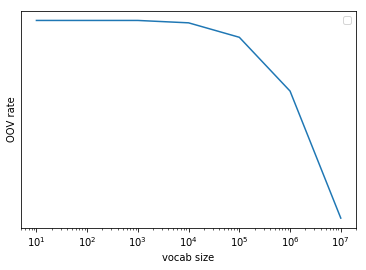

In [7]:
oov.plot_oov_rates(oov_rates)

##### tuned char-model

In [8]:
GEN_DATA_PATH = "data/generated/hd150_cl50_3_bng_tr_chr_50/"
MODEL_PATH = f"./rnnlm_models/hd150_cl50_3_bng_tr_chr_50"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [10]:
# Decoding generated texts
sentpiece.desegmentation("data/generated/hd150_cl50_3_bng_tr_chr_50/100.txt", "bng_train_50")

In [15]:
dir_path="data/generated/hd150_cl50_3_bng_tr_chr_50/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_50")
        
    add_vocab = oov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = oov.compute_oov_rate(oov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

No handles with labels found to put in legend.


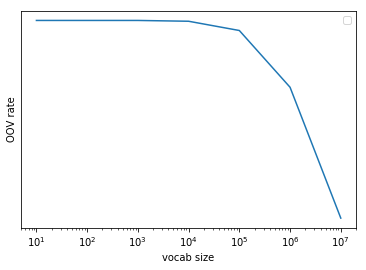

In [14]:
oov.plot_oov_rates(oov_rates)

### baseline small word-level model

In [14]:
GEN_DATA_PATH = "data/generated/bng_tr_chr_200/" 
MODEL_PATH = f"./rnnlm_models/bng_tr_chr_200"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [15]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/bng_tr_chr_200/100.txt", "bng_train_200")

##### OOV comparison

In [20]:
train_vocab, test_vocab = oov.get_vocab(TRAIN_DATA_PATH), oov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/bng_tr_chr_200/" 
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_200")
        
    add_vocab = oov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = oov.compute_oov_rate(oov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

No handles with labels found to put in legend.


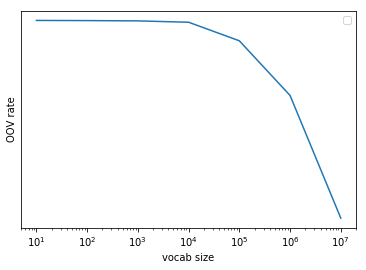

In [22]:
oov.plot_oov_rates(oov_rates)

### tuned small word-level model

In [5]:
GEN_DATA_PATH = "data/generated/hd200_cl200_3_bng_tr_chr_200/" 
MODEL_PATH = f"./rnnlm_models/hd200_cl200_3_bng_tr_chr_200" 

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [6]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/hd200_cl200_3_bng_tr_chr_200/100.txt", "bng_train_200")

##### OOV comparison

In [9]:
train_vocab, test_vocab = oov.get_vocab(TRAIN_DATA_PATH), oov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/hd200_cl200_3_bng_tr_chr_200/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_200")
        
    add_vocab = oov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = oov.compute_oov_rate(oov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

No handles with labels found to put in legend.


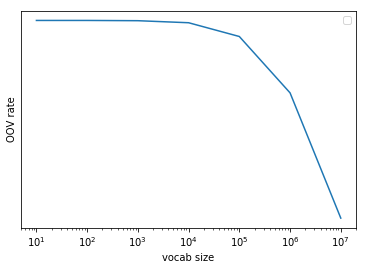

In [10]:
oov.plot_oov_rates(oov_rates)

### large word-level model

#### baseline

In [9]:
GEN_DATA_PATH = "data/generated/bng_tr_wd_1500/"
MODEL_PATH = f"./rnnlm_models/bng_tr_wd_1500"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [10]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/bng_tr_wd_1500/100.txt", "bng_train_1500")

##### OOV comparison

In [11]:
train_vocab, test_vocab = oov.get_vocab(TRAIN_DATA_PATH), oov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/bng_tr_wd_1500/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_1500")
        
    add_vocab = oov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = oov.compute_oov_rate(oov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

No handles with labels found to put in legend.


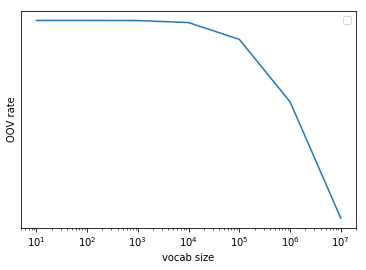

In [12]:
oov.plot_oov_rates(oov_rates)

### tuned large word model

In [13]:
GEN_DATA_PATH = "data/generated/hid50_bng_tr_wd_1500/"
MODEL_PATH = f"./rnnlm_models/hid50_bng_tr_wd_1500"

from pathlib import Path
Path(GEN_DATA_PATH).mkdir(parents=True, exist_ok=True)

!bash gen_script.sh $GEN_DATA_PATH $MODEL_PATH

In [14]:
# inspect 100.txt
sentpiece.desegmentation("data/generated/hid50_bng_tr_wd_1500/100.txt", "bng_train_1500")

##### OOV comparison

In [15]:
train_vocab, test_vocab = oov.get_vocab(TRAIN_DATA_PATH), oov.get_vocab(TEST_DATA_PATH) 

dir_path="data/generated/hid50_bng_tr_wd_1500/"
oov_rates = {}
for i in range(1,8):
    file=10**i
    print(file)
    if str(file)+"_desegmented.txt" not in os.listdir(dir_path):
        sentpiece.desegmentation(dir_path+str(file)+".txt", "bng_train_1500")
        
    add_vocab = oov.get_vocab(dir_path+str(file)+"_desegmented.txt")
    oov_rates[file] = oov.compute_oov_rate(oov.augment_vocab(train_vocab, add_vocab), test_vocab)
print(oov_rates)

No handles with labels found to put in legend.


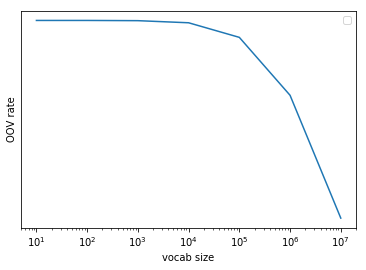

In [16]:
oov.plot_oov_rates(oov_rates)

## Inspection of 100.txts

In [5]:
# Observations from generated LM
sentpiece.show_desegmented_file("data/generated/bng_chr_50/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/bng_tr_chr_200/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/bng_tr_wd_1500/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/hd150_cl50_3_bng_tr_chr_50/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/hd200_cl200_3_bng_tr_chr_200/100_desegmented.txt")
sentpiece.show_desegmented_file("data/generated/hid50_bng_tr_wd_1500/100_desegmented.txt")

bng_chr_50
প্রকার ভিলতে ৷ত্কার নায়মে সে বিচারা করে আজদেরকে বছর্তার হাকিবেশ সাস্তি দেশে অনেক হিচাই দলাম করিস্প
bng_tr_chr_200
ম হলে সোনি করলে ছিলো সব ভূত্ণে রাউয়ের একটা নায়িকা আমি সিরিত্যাগুলো কেউ আডিসি আমি হেড়ে ছেলেঁদ করেইতোনগার আপনি থুতে ছিসির না অনিটা করায় ভাইকে বেঁরার ভাই করা যাবেনল মনে হয় সকল করে
bng_tr_wd_1500
ষড়ই লেগে নিসে তার জনপনা মারতে আসেনাএই ধরনের মোম্ম্বালা মিন্নি সব সোযত তাই না এ সরকারী ডিসির পিছন আর একটা খারাপ আর কেন উঠেছে একজন ফাসি চাই ভাইআসলে গেম হলেও কে বলছি আনি লেয়েলতা হবে পতিতা আরেকটা জ্বলা আমার গু ম্যাজি রুবেলের সাথে সঝজব করুন তার বাজে গাঁ সবার মানুষগুলোরলিগার রিকামুর দৃত্যে কোন কথা কি চোখে
hd150_cl50_3_bng_tr_chr_50
তার মেয়ে চুবু,,আমার চাকরি অাবন্ধ করেতোর সাবের ছিব তাহেমিকের মত মতো বলে সবার জন্য জপ্রাটকন্যাবাদুকী
hd200_cl200_3_bng_tr_chr_200
রেখারএই হবে কেমনে হতে হবে বোঝেছ সেই শাস্তি দিয়া গেছে সব জাজাইবটে কি আর করুক একজন নয়নটা হাগারটাকে প্রথমেয়ে স্রেষ্ঠের আতাএসো কোথা হতে কেকভারতে গেয় এগিয়ে যাচ্ছে জীবনম দেখ
hid50_bng_tr_wd_1500
এঙ্গারছাগলএডরিভারতে চাই 

Due to our lack of understanding of texts in Bengali, we cannot exactly comment on the quality of generated data. It can be seen in the output of the tuned character-level model (hd150_cl50_3_bng_tr_chr_50 ) that two commas follow each other, so we assume the text generated by character-level model would lack coherence due to lack of context. However, the text generated by larger subword units would output a better quality text due to more context.


### Observations


#### baseline models

| Language |   Level   | Voc. size | Hyperparams (hid-class-bptt) | Perplexity | OOV rate % (BS: 13.43%) |
|:--------:|:---------:|:---------:|:--------------------------:|:----------:|:-------------------:|
|  Bengali | Character |     50    |          40-9999-3         |  9.782082  |        11.53        |
|  Bengali |   Small   |    200    |          40-9999-3         |  51.326691 |        10.96        |
|  Bengali |   Large   |    1500   |          40-9999-3         | 319.937888 |        10.26        |

#### tuned models 
| Language |   Level   | Voc. size | Hyperparams (hid-class-bptt) | Perplexity | OOV rate % (BS: 13.43%) |
|:--------:|:---------:|:---------:|:--------------------------:|:----------:|:--------------------:|
|  Bengali | Character |     50    |          150-50-3          |  7.537116  |         11.13        |
|  **Bengali** |   **Small**   |    **200**    |          **200-200-3**         |  **40.404075** |         **10.57**        |
|  Bengali |   Large   |    1500   |          50-9999-3         | 315.655359 |         10.21        |


As expected, the added vocabulary from language models lowers the OOV rate. Across all models, the highest difference in oov rate is observed with the 10^7-sized LM generated text. So, for comparison with the baseline, we consider the OOV-rate corresponding to this augmentation. <br>
The baseline OOV rate of 13.43% goes down to 11.13% with tuned character-level LM. It is further reduced to 10.57% and 10.21% with tuned small and large subword-level LMs, respectively. However, we can clearly observe that the reduced OOV rates come at the price of increasing perplexity. <br>
As the vocab-size of the LM increases, perplexity increases at a much faster rate than OOV rate. Experiments with vocab size larger than 1500 (eg. with vocab size 2500) showed perplexities as high as 460.93 for baseline and 457.38 for the tuned model. But there wasn't a significant difference in its OOV rate as compared to the 1500-vocab-sized model (10.19% for baseline and 10.16% for tuned). <br>
**For practical purposes, we would choose the the tuned small word-level model, since it gives both a decent perplexity and a decent OOV-rate as compared to the other models.**  

# Analysis

#### what we aimed to achieve
The goal of this project was to find optimal subwords and train a language model over these subwords to alleviate the OOV problem in two morphologically distinct languages: English and Bengali. This was done by augmenting the train data with the data generated by trained language models and finding the optimal OOV rate on the test set using the augmented train corpora.  <br>

#### summary of our observations for all tasks, hyperparameter tuning and ways to improve results
1. Data Preparation: After manually inspecting both corpora, following preprocessing steps are done: 

    For English:
        - Simple noise removal: asterisk (*) symbols are removed, sequences ‘_I_’ are substituted with the character ‘I’ and sequences ‘--’ are substituted with whitespaces.
        - Lowercasing: In order to reduce vocabulary size, however, we should experiment and test results without lowercasing.
        - Other methods (e.g. stemming, stopwords removal, expendin contractions) are not used since it is a language modeling task and we want to preserve language style.  

    For Bengali, we split the sentences using html line break tags and punctuations such as "।!?".Furthermore, we remove English words/characters, numbers, other html tags and emoji flags. This gives us 10861 sentences in train and 2716 sentences in test. 


2. Subword Segmentation  
Experiments for the subword-unit granulatiy levels for Bengali were conducted on the same range of vocab-size as given for English. Segmented files with vocab size >=300 were found to have more than two-syllable subword units. Therefore for closer-to-character granularity level, we chose 200 as the vocab size as it showed a good mix of single characters, one-syllable and two-syllable subword units.  
As for closer-to-word granularity level, we choose 1500 as the vocab size because it gives a good mix of word-level tokens for shorter words and subword tokens for longer words. Beyond this value (1500), we see a higher proportion of word-level tokens in the segmented files. 

    For English:<br>
    As expected, for the character-based model every word is chopped to character units, therefore, the whole file is a collection of characters separated by whitespaces.
    Using vocabulary of size 100 tokens, overall sparse representation (words are still pretty much chopped into character units and small n-grams (e.g. bigrams)) can be observed. However, highly frequent words, like _and and _the, are now part of the vocabulary.
    Lastly, when vocabulary size is increased to 2500, an increased number of whole words are present in the vocabulary, while OOV words are composed of multiple vocabulary words. For instance, absurd is composed of _abs ur d, since ur is an extremely frequent bigram (e.g. four, your, etc.), while _abs shows up a few times.
    Furthermore, vocabulary size is determined using baseline setup (hyperparameters 40-9999-3) and running training on various vocabulary sizes. Selected ones for small and large instances had the lowest perplexities. Additionally, differences in vocabularies with similar scores were negligible, thus, those with the lowest perplexity scores were selected.


3. LM Training  
In Bengali, it was empirically seen that increasing the hidden layer size for smaller subword units (characters and closer-to-character subwords) lowered the perplexity at a faster rate. This makes sense because we have higher number of training tokens for these two granularity levels than that of closer-to-word subword units. Moreover, setting the `class` parameter=vocab size gave better perplexities for both models. <br>
For closer-to-word granularity level, we found the optimal hidden layer size to be 50. Any value lower or higher than that gave higher perplexities with same `class` and `bptt` parameter. As for the class parameter, values <= vocab size performed worse than the given baseline value. Also, values > baseline `class` parameter gave higher perplexities. 
Finally, we also experimented with different `bptt` values (by fixing `class` and `hidden_layer_size`). The baseline `bptt` parameter outperformed consistently on all models, therefore, we do not change it.  

    In English, increasing hidden layer size resulted in lower perplexity in general, however, selected values are produced the best OOV rates. Furthermore, the class parameter value was the best in neighbourhood of vocabulary size. Lastly, the bptt parameter was selected in the same manner as for Bengali.

To further improve results, we would follow the suggestion for best accuracy as given in the [original paper](http://www.fit.vutbr.cz/~imikolov/rnnlm/rnnlm-demo.pdf).  


#### whether our expectations were fulfilled  
Yes, we achieved significantly lower OOV-rates than the baseline with all our models. 

#### takeaways from this project 
- We learnt how subword representations can be used to achieve a lower OOV rate in language models. How such representations give different results for morphologically diverse languages.
- Morphologically richer languages, like Bengali, are harder to model which can be seen from the difference in OOV rates. Furthermore, we should have understanding of a language in order to better inspect the results and further improve the language model.

#### how do results differ for English and Bengali
We assumed the task of solving OOV word problem for the morpholoically richer language, Bengali, to be much harder than that for English. This can be seen emperically from the baseline OOV rate of the corpora of the two languages. As for the improvement of OOV rate from augmented data, we see both languages follow almost the same trend. That is, for smaller granularities (character and closer-to-character level), visible decrease starts after 10^4 text length in both the languages. However, in case of large subword level, a noticeable decrease can be seen in English after 10^3 text length but in Bengali from 10^4 onwards.
